# Import Library

In [20]:
from rdkit import Chem
import math
import pandas as pd
import pickle
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
import numpy as np
from torch_geometric.nn import GINConv, GINEConv, GCNConv, SAGEConv, global_add_pool, global_mean_pool
from torch.nn import Sequential, Linear, BatchNorm1d, ReLU, Dropout
import torch.nn.functional as F
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Run Pytorch on CUDA

In [21]:
def format_pytorch_version(version):
    return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
    return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# DataSet & DataLoader

## Generate Data

In [22]:
df = pd.read_csv('data/train/clean_train.csv')
smiles = pd.read_csv('data/train/smiles_train.csv')
mol2vec = pickle.load(open('data/train/mol2vec.pkl', 'rb'))
data = df.join(smiles.set_index('MOFname'), on='MOFname')

mask = ~data['Smiles'].isnull().values
mol2vec = mol2vec[mask]
data = data.dropna(subset=['Smiles'])
data = data.reset_index(drop=True)
print(data.isnull().sum())
print(data.shape)

topo_0                                           0
topo_1                                           0
topo_2                                           0
topo_3                                           0
topo_4                                           0
topo_5                                           0
topo_6                                           0
topo_7                                           0
topo_8                                           0
topo_9                                           0
MOFname                                          0
volume [A^3]                                     0
weight [u]                                       0
density [g/cm^3]                                 0
surface_area [m^2/g]                             0
void_fraction                                    0
void_volume [cm^3/g]                             0
functional_groups                                0
metal_linker                                     0
organic_linker1                

In [31]:
x_map = {
    'atomic_num':
    list(range(0, 119)),
    'chirality': [
        'CHI_UNSPECIFIED',
        'CHI_TETRAHEDRAL_CW',
        'CHI_TETRAHEDRAL_CCW',
        'CHI_OTHER',
    ],
    'degree':
    list(range(0, 11)),
    'formal_charge':
    list(range(-5, 7)),
    'num_hs':
    list(range(0, 9)),
    'num_radical_electrons':
    list(range(0, 5)),
    'hybridization': [
        'UNSPECIFIED',
        'S',
        'SP',
        'SP2',
        'SP3',
        'SP3D',
        'SP3D2',
        'OTHER',
    ],
    'is_aromatic': [False, True],
    'is_in_ring': [False, True],
}

e_map = {
    'bond_type': [
        'misc',
        'SINGLE',
        'DOUBLE',
        'TRIPLE',
        'AROMATIC',
    ],
    'stereo': [
        'STEREONONE',
        'STEREOZ',
        'STEREOE',
        'STEREOCIS',
        'STEREOTRANS',
        'STEREOANY',
    ],
    'is_conjugated': [False, True],
}

In [37]:
data_list = []
data_dict = []
c = 1
for idx, line in data.iterrows():
    mol = Chem.MolFromSmiles(line['Smiles'])
    
    if mol == None:
        continue
    
    # Create Node Features
    xs = []
    for atom in mol.GetAtoms():
        x = []
        x.append(x_map['atomic_num'].index(atom.GetAtomicNum()))
        x.append(x_map['chirality'].index(str(atom.GetChiralTag())))
        x.append(x_map['degree'].index(atom.GetTotalDegree()))
        x.append(x_map['formal_charge'].index(atom.GetFormalCharge()))
        x.append(x_map['num_hs'].index(atom.GetTotalNumHs()))
        x.append(x_map['num_radical_electrons'].index(atom.GetNumRadicalElectrons()))
        x.append(x_map['hybridization'].index(str(atom.GetHybridization())))
        x.append(x_map['is_aromatic'].index(atom.GetIsAromatic()))
        x.append(x_map['is_in_ring'].index(atom.IsInRing()))
        xs.append(x)
    x = torch.tensor(xs, dtype=torch.float).view(-1, 9)
    
    # Create Edge Features
    edge_indices, edge_attrs = [], []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()

        e = []
        e.append(e_map['bond_type'].index(str(bond.GetBondType())))
        e.append(e_map['stereo'].index(str(bond.GetStereo())))
        e.append(e_map['is_conjugated'].index(bond.GetIsConjugated()))

        edge_indices += [[i, j], [j, i]]
        edge_attrs += [e, e]

    edge_index = torch.tensor(edge_indices)
    edge_index = edge_index.t().to(torch.long).view(2, -1)
    edge_attr = torch.tensor(edge_attrs, dtype=torch.long).view(-1, 3)

    # Sort indices.
    if edge_index.numel() > 0:
        perm = (edge_index[0] * x.size(0) + edge_index[1]).argsort()
        edge_index, edge_attr = edge_index[:, perm], edge_attr[perm]

    x_feat = line.drop(['MOFname', 'weight [u]', 'functional_groups', 'CO2_working_capacity [mL/g]', 'Smiles']).values.astype(float) #, 'weight [u]', 'functional_groups', 'CO2_working_capacity [mL/g]'
    x_feat = np.expand_dims(x_feat, axis=0)
    x_feat = torch.tensor(x_feat)
    
    vec = np.expand_dims(mol2vec[idx], axis=0)
    vec = torch.tensor(vec)
    
    x_feat = torch.cat((x_feat, vec), dim=1)
    
    y=torch.tensor([line['CO2_working_capacity [mL/g]']], dtype=torch.float).view(1, -1)
    
    data_d = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y, smiles=line['Smiles'], mofname=line['MOFname'], x_feat=x_feat) #, y=y
    data_d.num_nodes = len(mol.GetAtoms())
    data_list.append(data_d)
    data_dict.append(line['MOFname'])
    
    if(c%10000==0):
        print('done:',c)
    c=c+1

done: 10000
done: 20000
done: 30000
done: 40000
done: 50000
done: 60000


## Load Data

In [23]:
data_list = pickle.load(open('data/train/graph_vec.pkl', 'rb'))

In [24]:
import random
random.seed(10)

datasets = data_list

train_dataset, test_dataset = train_test_split(datasets, test_size=0.16, random_state = 1, shuffle=True)

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 55125
Number of test graphs: 10500


In [25]:
train_feat = []
test_feat = []

for train_data in train_dataset:
    train_feat.append(train_data.x_feat)
    
for test_data in test_dataset:
    test_feat.append(test_data.x_feat)


train_feat = torch.cat(train_feat, axis=0)
test_feat = torch.cat(test_feat, axis=0)

sc = StandardScaler()
train_feat = torch.from_numpy(sc.fit_transform(train_feat))
test_feat = torch.from_numpy(sc.transform(test_feat))

for i, data in enumerate(train_dataset):
    data.x_feat = train_feat[i].unsqueeze(0)

for i, data in enumerate(test_dataset):
    data.x_feat = test_feat[i].unsqueeze(0)

In [26]:
from torch_geometric.loader import DataLoader
import numpy as np

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
data_loader = DataLoader(datasets, batch_size=128, shuffle=True)

# Model

## GINE Model

In [27]:
class GINE(torch.nn.Module):
    def __init__(self, in_channels, in_attr, dim, out_channels):
        super(GINE, self).__init__()

        self.attr1 = Sequential(Linear(in_attr, in_channels), BatchNorm1d(in_channels), ReLU())
        self.conv1 = GINEConv(
            Sequential(Linear(in_channels, dim), BatchNorm1d(dim), ReLU(),
                       Linear(dim, dim), ReLU()))

        self.attr2 = Sequential(Linear(in_channels, dim), BatchNorm1d(dim), ReLU())
        self.conv2 = GINEConv(
            Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU(),
                       Linear(dim, dim), ReLU()))

        self.attr3 = Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU())
        self.conv3 = GINEConv(
            Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU(),
                       Linear(dim, dim), ReLU()))

        self.attr4 = Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU())
        self.conv4 = GINEConv(
            Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU(),
                       Linear(dim, dim), ReLU()))

        self.attr5 = Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU())
        self.conv5 = GINEConv(
            Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU(),
                       Linear(dim, dim), ReLU()))

        self.lin1 = Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU())
        self.lin2 = Linear(dim, out_channels)

    def forward(self, x, edge_index, edge_attr, batch):
        edge_attr = self.attr1(edge_attr)
        x = self.conv1(x, edge_index, edge_attr)
        
        edge_attr = self.attr2(edge_attr)
        x = self.conv2(x, edge_index, edge_attr)
        
        edge_attr = self.attr3(edge_attr)
        x = self.conv3(x, edge_index, edge_attr)
        
        edge_attr = self.attr4(edge_attr)
        x = self.conv4(x, edge_index, edge_attr)
        
        edge_attr = self.attr5(edge_attr)
        x = self.conv5(x, edge_index, edge_attr)
        
        x = global_add_pool(x, batch)
        x = self.lin1(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

In [28]:
class GIN(torch.nn.Module):
    def __init__(self, in_channels, dim, out_channels):
        super(GIN, self).__init__()

        self.conv1 = GINConv(
            Sequential(Linear(in_channels, dim), BatchNorm1d(dim), ReLU(),
                       Linear(dim, dim), ReLU()))

        self.conv2 = GINConv(
            Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU(),
                       Linear(dim, dim), ReLU()))

        self.conv3 = GINConv(
            Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU(),
                       Linear(dim, dim), ReLU()))

        self.conv4 = GINConv(
            Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU(),
                       Linear(dim, dim), ReLU()))

        self.conv5 = GINConv(
            Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU(),
                       Linear(dim, dim), ReLU()))

        self.lin1 = Linear(dim, dim)
        self.lin2 = Linear(dim, out_channels)
        self.lin3 = Linear(out_channels, out_channels)



    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        x = self.conv3(x, edge_index)
        x = self.conv4(x, edge_index)
        x = self.conv5(x, edge_index)
        x = global_add_pool(x, batch)
        x = self.lin1(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin3(x)
        return x

In [29]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, dim, out_channels):
        super(GCN, self).__init__()

        self.conv1 = GCNConv(in_channels, dim)
        self.conv2 = GCNConv(dim, dim)
        self.conv3 = GCNConv(dim, dim)
        self.conv4 = GCNConv(dim, dim)
        self.lin = Linear(dim, out_channels)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index).relu()
        x = self.conv4(x, edge_index).relu()
        x = global_mean_pool(x, batch)
        x = self.lin(x).relu()
        return x

In [30]:
class SAGE(torch.nn.Module):
    def __init__(self, in_channels, dim, out_channels):
        super(SAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, dim)
        self.conv2 = SAGEConv(dim, dim)
        self.conv3 = SAGEConv(dim, dim)
        self.conv4 = SAGEConv(dim, dim)
        self.lin = Linear(dim, out_channels)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index).relu()
        x = self.conv4(x, edge_index).relu()
        x = global_mean_pool(x, batch)
        x = self.lin(x).relu()
        return x

## MLP Model

In [31]:
class MLP(torch.nn.Module):
    def __init__(self, in_channels, dim, out_channels):
        super(MLP, self).__init__()

        self.lin1 = Linear(in_channels, dim)
        self.lin2 = Linear(dim, dim)
        self.lin3 = Linear(dim, dim)
        self.lin4 = Linear(dim, out_channels)

    def forward(self, x):
        x = self.lin1(x).relu()
        x = self.lin2(x).relu()
#         x = self.lin3(x).relu()
        x = self.lin4(x).relu()
        return x

## Cross Network

In [32]:
class CrossNet(nn.Module):

    def __init__(self, in_features, layer_num=2):
        super(CrossNet, self).__init__()
        self.layer_num = layer_num
        self.kernels = nn.Parameter(torch.Tensor(self.layer_num, in_features, 1))
        self.bias = nn.Parameter(torch.Tensor(self.layer_num, in_features, 1))

        for i in range(self.kernels.shape[0]):
            nn.init.xavier_normal_(self.kernels[i])
        for i in range(self.bias.shape[0]):
            nn.init.zeros_(self.bias[i])

        self.to(device)

    def forward(self, inputs):
        x_0 = inputs.unsqueeze(2)
        x_l = x_0
        for i in range(self.layer_num):
            xl_w = torch.tensordot(x_l, self.kernels[i], dims=([1], [0]))
            dot_ = torch.matmul(x_0, xl_w)
            x_l = dot_ + self.bias[i] + x_l
        x_l = torch.squeeze(x_l, dim=2)
        return x_l

## Multi Input Model

In [32]:
class Net(torch.nn.Module):
    def __init__(self, in_xs, in_attr, in_xfeats, dim, out_channels):
        super(Net, self).__init__()
        self.gine = GINE(in_xs, in_attr, dim, 128)
        self.mlp_num = MLP(in_xfeats, dim, 128)
        self.bn = BatchNorm1d(256)
        self.lin = Sequential(Linear(256, 128), BatchNorm1d(128))
        self.lin2 = Sequential(Linear(128, 128), BatchNorm1d(128))
        # Deep & Cross Network
        self.crossnet = CrossNet(128)
        self.mlp_cross = MLP(128, 256, 128)
        
        self.bn_cat = BatchNorm1d(256)
        self.mlp_cat = MLP(256, 256, 128)
        self.dropout = Dropout(p=0.5)
        self.out = Linear(128, out_channels) # 256

    def forward(self, x, edge_index, edge_attr, batch, x_feat):
        x = self.gine(x, edge_index, edge_attr, batch)
        x_feat = self.mlp_num(x_feat)
        concat = torch.cat((x, x_feat),dim=1)
        x = self.bn(concat)
        x = self.lin(x)
        x = self.lin2(x)
        
        # Deep & Cross Network
        hl = self.mlp_cross(x)
        xl = self.crossnet(x)
        x = torch.cat((xl, hl), dim=1)
        x = self.bn_cat(x)
        x = self.mlp_cat(x)
        x = self.dropout(x)
        out = self.out(x)
        return out

In [13]:
class Net(torch.nn.Module):
    def __init__(self, in_xs, in_attr, in_xfeats, dim, out_channels):
        super(Net, self).__init__()
        self.gin = GCN(in_xs, dim, 128)
        self.mlp_num = MLP(in_xfeats, dim, 128)
        self.bn = BatchNorm1d(256)
        # Deep & Cross Network
        self.crossnet = CrossNet(256, layer_num=2)
        self.mlp_cross = MLP(256, 256, 256)
        
        self.bn_cat = BatchNorm1d(256) #64+in_xfeats
        self.dropout = Dropout(p=0.5)
        self.out = Linear(256, out_channels) # 256

    def forward(self, x, edge_index, batch, x_feat):
        x = self.gin(x, edge_index, batch)
        x_feat = self.mlp_num(x_feat)
        concat = torch.cat((x, x_feat),dim=1)
        x = self.bn(concat)
        
        # Deep & Cross Network
        hl = self.mlp_cross(x)
#         xl = self.crossnet(x)
#         x = torch.cat((xl, hl), dim=1)
        x = self.bn_cat(hl)
        x = self.dropout(x)
        out = self.out(x)
        return out

In [62]:
class DCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DCN, self).__init__()
        # Deep & Cross Network
        self.crossnet = CrossNet(in_channels)
        self.mlp_cross = MLP(in_channels, 256, 128)
        
        self.bn = BatchNorm1d(128+in_channels)
        self.mlp_cat = MLP(128+in_channels, 512, 256)
        self.bn_out = BatchNorm1d(256)
        self.dropout = Dropout(p=0.5)
        self.out = Linear(256, out_channels) # 256

    def forward(self, x):        
        # Deep & Cross Network
        hl = self.mlp_cross(x)
        xl = self.crossnet(x)
        x = torch.cat((xl, hl), dim=1)
        x = self.bn(x)
        x = self.mlp_cat(x)
        x = self.bn_out(x)
#         x = self.dropout(x)
        out = self.out(x)
        return out

In [54]:
class Net(torch.nn.Module):
    def __init__(self, in_xs, in_xfeats, dim, out_channels):
        super(Net, self).__init__()

        self.g = SAGE(in_xs, dim, 32)
        self.mlp = MLP(in_xfeats, dim, 128)
        self.lin = Linear(160, 128)
        self.lin2 = Linear(128, 128)
        self.cross = CrossNet(128, layer_num=2)
        self.mlp_cross = MLP(128, 128, 128)
        self.mlp_out = MLP(256, 256, 256)
        self.out = Linear(256, out_channels)

    def forward(self, x, edge_index, batch, x_feat):
        x = self.g(x, edge_index, batch)
        x_feat = self.mlp(x_feat)
        concat = torch.cat((x, x_feat), dim=1)
        x = self.lin(concat)
        x = F.dropout(x, p=0.45, training=self.training)
#         x = self.lin2(x).relu()
        
        cross = self.cross(x)
        mlp_cross = self.mlp_cross(x)
        concat2 = torch.cat((cross, mlp_cross), dim=1)
        
        x = self.mlp_out(concat2)
        x = F.dropout(x, p=0.45, training=self.training)
        out = self.out(x)
        return out

# Train

In [55]:
def train(train_loader):
    model.train()
    c=0
    correct=0
    for data in train_loader:  # Iterate in batches over the training dataset.
        data.to(device)
        out = model(data.x, data.edge_index, data.batch, data.x_feat.float())  # Perform a single forward pass. , data.edge_attr.float()
    
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

        c=c+1
        correct+=loss.cpu().detach().numpy()
    return correct/c

def test(loader):
    model.eval()
    correct = 0
    c=0
    for data in loader:  # Iterate in batches over the training/test dataset.
        data.to(device)
        out = model(data.x, data.edge_index, data.batch, data.x_feat.float()) # , data.edge_attr.float()
    
        loss = criterion(out, data.y)  # Compute the loss.
        correct += loss.cpu().detach().numpy()  # Check against ground-truth labels.
        c=c+1
    return correct / c  # Derive ratio of correct predictions.

In [56]:
num_node_features = 9
hidden_channels = 32
num_feats = 321
num_classes = 1
num_attr = 3

model = Net(num_node_features, num_feats, hidden_channels, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #0.001
criterion = torch.nn.L1Loss()
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.85, patience=3, min_lr=0.000001)

In [57]:
train_loss = []
test_loss = []
epochs = 200
print('start train')

for epoch in range(epochs):
    train_acc = train(train_loader)
    test_acc = test(test_loader)
    train_loss.append(train_acc)
    test_loss.append(test_acc)
    scheduler.step(test_acc)
    print(f'Epoch: {epoch+1:03d}, Train MAE: {train_acc:.4f}, Test MAE: {test_acc:.4f}')

start train
Epoch: 001, Train MAE: 43.1645, Test MAE: 28.9799
Epoch: 002, Train MAE: 29.7585, Test MAE: 27.4609
Epoch: 003, Train MAE: 27.7953, Test MAE: 24.9166
Epoch: 004, Train MAE: 26.6667, Test MAE: 23.8573
Epoch: 005, Train MAE: 25.8521, Test MAE: 24.7507
Epoch: 006, Train MAE: 25.2811, Test MAE: 26.7993
Epoch: 007, Train MAE: 25.6200, Test MAE: 24.5208
Epoch: 008, Train MAE: 24.8878, Test MAE: 24.2621
Epoch: 009, Train MAE: 24.5576, Test MAE: 22.2441
Epoch: 010, Train MAE: 24.1108, Test MAE: 21.7956
Epoch: 011, Train MAE: 23.8442, Test MAE: 21.7565
Epoch: 012, Train MAE: 23.8400, Test MAE: 22.7404
Epoch: 013, Train MAE: 23.6072, Test MAE: 21.3739
Epoch: 014, Train MAE: 23.3343, Test MAE: 22.2586
Epoch: 015, Train MAE: 23.2439, Test MAE: 21.5691
Epoch: 016, Train MAE: 23.3776, Test MAE: 21.1030
Epoch: 017, Train MAE: 23.2465, Test MAE: 22.2006
Epoch: 018, Train MAE: 22.9827, Test MAE: 21.1285
Epoch: 019, Train MAE: 22.9257, Test MAE: 21.8906
Epoch: 020, Train MAE: 22.9070, Test M

KeyboardInterrupt: 

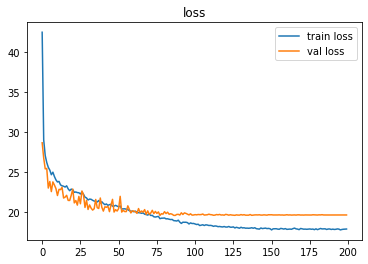

In [48]:
import matplotlib.pyplot as plt

plt.title('loss')
plt.plot(np.arange(epochs), train_loss, label='train loss')
plt.plot(np.arange(epochs), test_loss, label='val loss')
plt.legend()
plt.show()

In [127]:
save = False
if save:
    torch.save(model.state_dict(), "model/best_numGNN2.pt")

# Inference

## Preprocess Data

In [16]:
train_dataset = pickle.load(open('data/train/graph_concat.pkl', 'rb'))
test_dataset = pickle.load(open('data/test/graph_concat.pkl', 'rb'))

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 65625
Number of test graphs: 16237


In [17]:
train_feat = []
test_feat = []

for train_data in train_dataset:
    train_feat.append(train_data.x_feat)
    
for test_data in test_dataset:
    test_feat.append(test_data.x_feat)


train_feat = torch.cat(train_feat, axis=0)
test_feat = torch.cat(test_feat, axis=0)

sc = StandardScaler()
train_feat = torch.from_numpy(sc.fit_transform(train_feat))
test_feat = torch.from_numpy(sc.transform(test_feat))

for i, data in enumerate(train_dataset):
    data.x_feat = train_feat[i].unsqueeze(0)

for i, data in enumerate(test_dataset):
    data.x_feat = test_feat[i].unsqueeze(0)

In [134]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## Train all Data

In [114]:
num_node_features = 9
hidden_channels = 32
num_feats = 21
num_classes = 1
num_attr = 3

model = Net(num_node_features, num_feats, hidden_channels, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #0.001
criterion = torch.nn.L1Loss()
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.85, patience=3, min_lr=0.000001)

In [ ]:
train_loss = []
epochs = 200
print('start train')

for epoch in range(epochs):
    train_acc = train(train_loader)
    train_loss.append(train_acc)
    scheduler.step(test_acc)
    print(f'Epoch: {epoch+1:03d}, Train MAE: {train_acc:.4f}')

## Evaluate Test

In [210]:
mofname = []
co2_select = []

for data in test_loader:  # Iterate in batches over the training dataset.
    data.to(device)
    
    out = model(data.x, data.edge_index, data.batch, data.x_feat.float()).cpu().detach().numpy()
    mofname.append(data.mofname)
    co2_select.append(out)
    
mofname = np.concatenate(mofname)
co2_select = np.concatenate(co2_select).flatten()

cut_mof_unit = lambda x: x.split('_')[-1]
id_ = np.array(list(map(cut_mof_unit, mofname)))

In [211]:
d = {'id': id_, 'CO2_working_capacity [mL/g]': co2_select}

df_inference = pd.DataFrame(d)

In [212]:
df_xgboost = pd.read_csv('xgboost_submission.csv')
df_xgboost = df_xgboost.set_index('id')

df_xgboost.loc[df_inference.id.values.astype(int)] = np.expand_dims(df_inference['CO2_working_capacity [mL/g]'].values, axis=1)
df_xgboost = df_xgboost.reset_index()

In [213]:
df_xgboost.to_csv('submission.csv', index=False)

In [214]:
df_xgboost

,id,CO2_working_capacity [mL/g]
0,68614,195.468613
1,68615,69.653137
2,68616,66.580437
3,68617,55.399101
4,68618,64.502907
...,...,...
16995,85609,-6.392035
16996,85610,1.936134
16997,85611,0.404633
16998,85612,-1.013318
